## Методические указания по выполнению лабораторной работы №4

**Тема: Сегментация объектов с использованием Mask R-CNN**

**Цель работы:** Познакомиться с архитектурой Mask R-CNN и научиться выполнять сегментацию объектов на изображениях.

**Задачи:**

- Изучить теоретические основы instance segmentation.
- Ознакомиться с архитектурой Mask R-CNN.
- Провести инференс предобученной модели на выбранных изображениях.
- Визуализировать результаты: bounding boxes, маски объектов.
- Рассчитать метрики оценки качества масок.
- Проанализировать ошибки сегментации.
- Провести исследование зависимости качества от параметров confidence score и mask threshold.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Mask R-CNN](https://arxiv.org/pdf/1703.06870), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новой задачей компьютерного зрения - сегментацией. 

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/main/models/mask_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Instance Segmentation и архитектура Mask R-CNN

Instance segmentation — это задача, в которой необходимо не только обнаружить объект и его класс, но и сегментировать его границы на уровне пикселей. Это усложнённая версия задачи детекции, так как bounding box не всегда точно соответствует форме объекта.

В отличие от semantic segmentation, где модель выдает одну маску на класс, в instance segmentation выделяется каждый объект независимо, даже если они относятся к одному классу.

Mask R-CNN — это расширение Faster R-CNN, дополненное ещё одним выходом: бинарной маской для каждого обнаруженного объекта.

Архитектура Mask R-CNN включает:

1. Backbone (например, ResNet-50) — извлекает карты признаков из изображения.
2. Region Proposal Network (RPN) — предлагает кандидаты на объекты.
3. ROI Align / ROI Pooling — извлекает фиксированные области из фичей.
4. Bounding Box Head — классифицирует объект и уточняет координаты.
5. Mask Head — предсказывает маску для каждого класса, соответствующую bounding box.


#### 1.2 Формат данных для задачи детекции

При запуске инференса модель возвращает словарь с результатами: координаты bounding boxes, классы объектов, confidence score и маски объектов (представлены как float значения от 0 до 1).

В рамках выполнения работы в зависимости от варианта вам предстоит познакомиться с другими форматами файлов и их содержимым.

### Варианты 

Выполните задание в соответствии со своим вариантом по списку с использованием предобученной модели. 

**Вариант 1  - Pascal VOC 2007. Сравнить предсказания модели с реальной разметкой и провести количественную оценку:**

- Выполнить инференс модели на 20 изображениях;
- Визуализировать bounding boxes и маски;
- Проанализировать качество предсказаний;
- Описать, какие классы модель распознала, какие пропустила.

**Вариант 2(наш) — COCO 2017. Сравнить предсказания модели с реальной разметкой и провести количественную оценку:**

- Выполнить инференс на 20 изображениях;
- Визуализировать предсказания;
- Сравнить полученные маски с ground truth;
- Рассчитать IoU, Pixel Accuracy или Precision/Recall; 

**Вариант 3 — Cityscapes. Проверить, как модель работает на новых изображениях, визуализировать предсказания и сравнить с известными аннотациями:**

- Выполнить инференс на 20 изображениях;
- Визуализировать предсказания; 
- Сравнить полученные маски с ground truth;
- Рассчитать IoU, Pixel Accuracy или Precision/Recall;


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection

from pycocotools.coco import COCO

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [2]:
# импорт модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Используемое устройство: cpu


c:\Users\ttemuchin4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ttemuchin4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель:

In [3]:
# загрузка датасета
import os
data_dir = os.path.expanduser('~/Downloads/coco/coco2017')
ann_file = os.path.join(data_dir, 'annotations', 'instances_val2017.json')
img_dir = os.path.join(data_dir, 'val2017')

if not os.path.exists(ann_file):
    raise FileNotFoundError(f"ERROR - COCO annotations not found at {ann_file}\n")

# метод трансформации
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

val_dataset = CocoDetection(
    root=img_dir,
    annFile=ann_file,
    transform=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


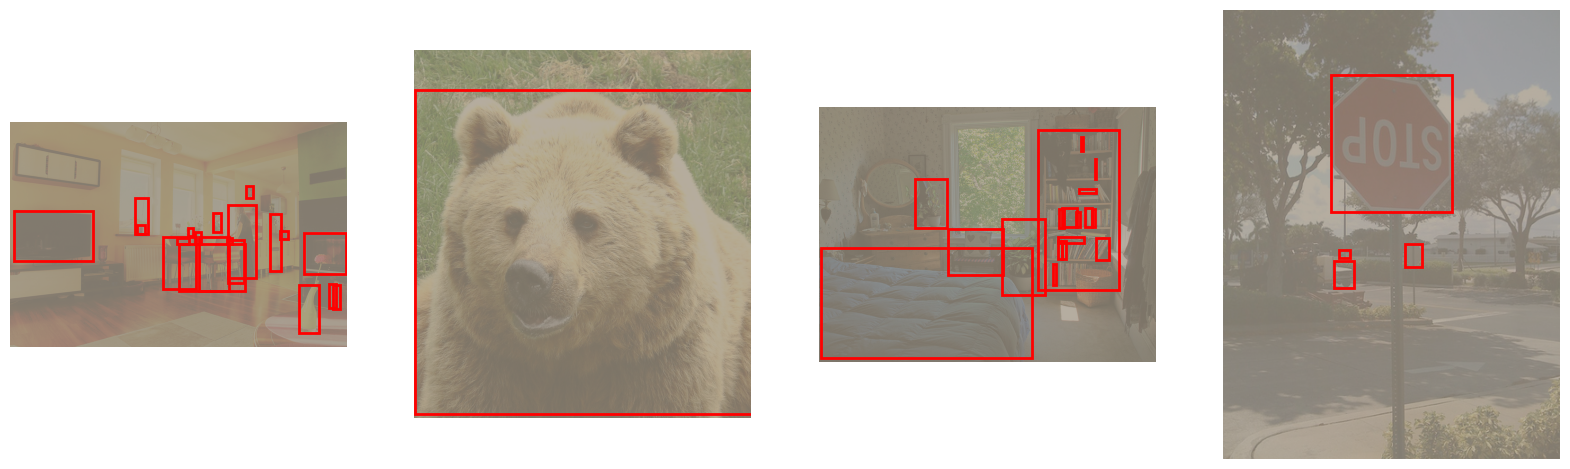

In [4]:
def denormalize(tensor):
    # Обратная нормализация для визуализации
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return tensor * std + mean

def show_batch(batch):
    images, targets = batch
    fig, axs = plt.subplots(1, len(images), figsize=(20, 20))
    
    if len(images) == 1:
        axs = [axs]

    for idx, (image, target) in enumerate(zip(images, targets)):
        # Денормализация
        img = denormalize(image).permute(1, 2, 0).cpu().numpy()
        
        axs[idx].imshow(img)
        axs[idx].axis('off')
        
        # боксы из аннотаций
        for ann in target:
            bbox = ann['bbox']
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2], bbox[3],
                fill=False,
                color='red',
                linewidth=2
            )
            axs[idx].add_patch(rect)
    
    plt.show()

batch = next(iter(val_dataloader))
show_batch(batch)

#### 2.4 Предсказания и извлечение масок

Если вы работаете с Pascal VOC, вам потребуется прочитать файлы, содержащие разметку. Если вы работаете с COCO или Cityscapes, аннотации читаются через готовые методы COCO API:

In [ ]:
# методы извлечения меток и визуализации
coco = COCO(ann_file)

def load_image(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    img = Image.open(img_path).convert('RGB')
    return torchvision.transforms.ToTensor()(img)

def get_gt_masks(img_id):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    return [coco.annToMask(ann) for ann in anns], [ann['category_id'] for ann in anns]

def calculate_px_metrics(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    
    tp = np.sum(intersection)
    fp = np.sum(np.logical_and(pred_mask, np.logical_not(gt_mask)))
    fn = np.sum(np.logical_and(np.logical_not(pred_mask), gt_mask))
    
    iou = tp / (np.sum(union) + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    accuracy = (tp + np.sum(np.logical_and(np.logical_not(pred_mask), np.logical_not(gt_mask)))) / (gt_mask.size + 1e-6)
    return iou, accuracy, precision, recall, fp, fn, tp

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


#### 2.5 Оценка модели и визуализация результатов

Визуализируйте bounding box, название класса, маску поверх изображения. Для каждой маски и её соответствующего ground truth (если имеется), вычислите: IoU, количество FP пикселей, количество FN пикселей:

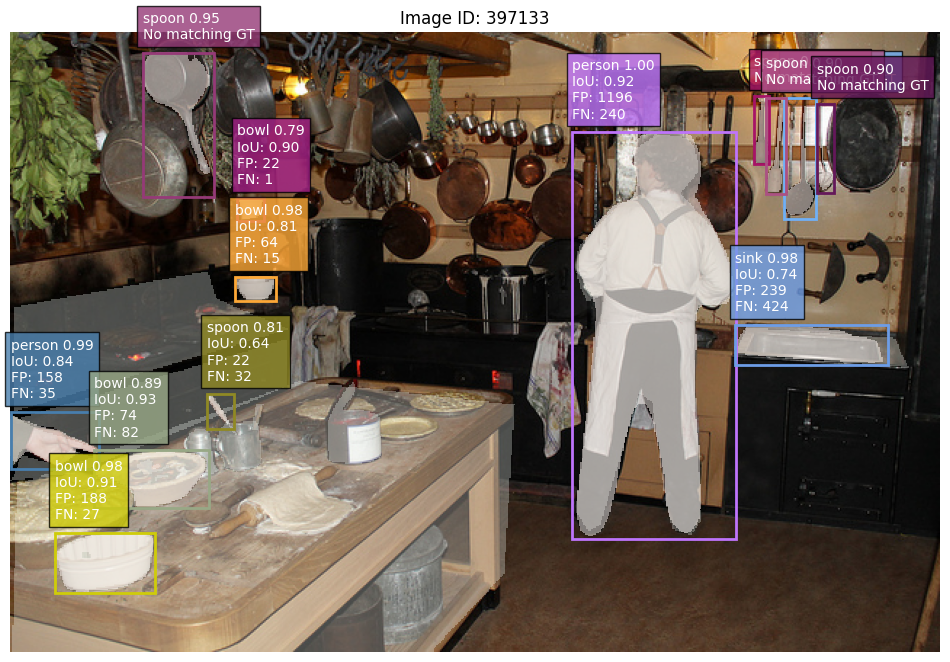

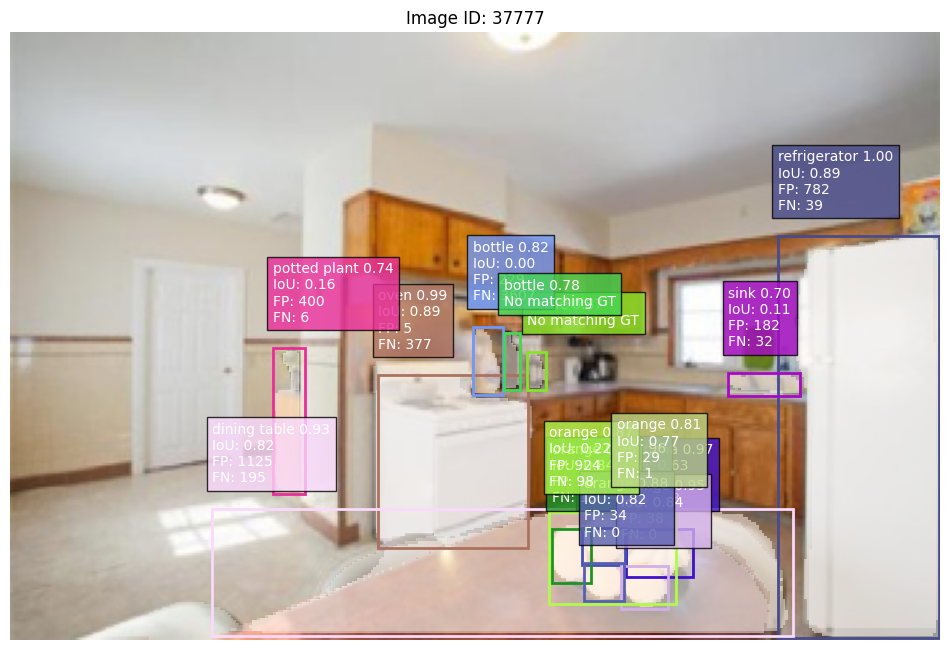

In [12]:
img_ids = coco.getImgIds()[:2]#снизили до 2, тк слишком много весит для ЛМС

for img_id in img_ids:
    image = load_image(img_id)
    gt_masks, gt_cat_ids = get_gt_masks(img_id)
    
    with torch.no_grad():
        pred = model([image])[0]
    
    # фильтруем
    keep = pred['scores'] > 0.7
    pred_masks = pred['masks'][keep].cpu().numpy() > 0.5
    pred_boxes = pred['boxes'][keep].cpu().numpy()
    pred_scores = pred['scores'][keep].cpu().numpy()
    pred_labels = pred['labels'][keep].cpu().numpy()
    
    fig, ax = plt.subplots(1, figsize=(12, 12))
    img = image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    
    for gt_mask, cat_id in zip(gt_masks, gt_cat_ids):
        color = np.random.rand(3,)
        gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
        ax.imshow(gt_mask, alpha=0.3, cmap='Greens')
    
    for i, (mask, box, score, label) in enumerate(zip(pred_masks, pred_boxes, pred_scores, pred_labels)):
        mask = mask[0]
        
        # ищем GT с макс IoU
        best_iou = 0
        best_gt_idx = -1
        for j, gt_mask in enumerate(gt_masks):
            iou, accuracy, precision, recall, fp, fn, tp = calculate_px_metrics(mask, gt_mask)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
    
        if best_gt_idx != -1:
            iou, accuracy, precision, recall, fp, fn, tp = calculate_px_metrics(mask, gt_masks[best_gt_idx])
            metrics_text = f"IoU: {iou:.2f}\nFP: {fp}\nFN: {fn}"
        else:
            metrics_text = "No matching GT"
        
        
        color = np.random.rand(3,)
        
        # bb
        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # mask
        masked = np.ma.masked_where(mask == 0, mask)
        ax.imshow(masked, alpha=0.5, cmap='Reds')
        
        try:
            cat_info = coco.loadCats([int(label)])[0]
            cat_name = cat_info['name']
        except (IndexError, TypeError):
            cat_name = f"Class_{label}"
    
        text = f"{cat_name} {score:.2f}\n{metrics_text}"
        ax.text(
            box[0], box[1]-10, text,
            color='white', fontsize=10,
            bbox={'facecolor': color, 'alpha': 0.8})
    
    plt.title(f"Image ID: {img_id}")
    plt.axis('off')
    plt.show()

#### 2.6 Исследование параметров маски и confidence

Проведите серию экспериментов: протестируйте разные значения mask_threshold (0.3, 0.5, 0.7), протестируйте разные значения confidence_threshold, найдите оптимальное значение, при котором достигается лучший баланс между точностью и полнотой:


In [7]:
# исследование
VISUALIZE = False
CONF_THRESHOLDS = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
MASK_THRESHOLDS = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
IOU_THRESHOLD = 0.3
img_ids = coco.getImgIds()
results = []

for conf_thresh in CONF_THRESHOLDS:

    for mask_thresh in MASK_THRESHOLDS:
        print("\n/// /// /// /// ///")
        print(f"CONF: {conf_thresh:.1f} | MASK: {mask_thresh:.1f} | IoU_MIN: {IOU_THRESHOLD:.1f}")
        
        total_metrics = {
            'true_pos': 0,
            'false_pos': 0,
            'false_neg': 0,
            'iou_sum': 0,
            'count': 0
        }

        for img_id in img_ids[:20]:
            # снова загрузка, предсказание
            image = load_image(img_id)
            gt_masks, gt_cat_ids = get_gt_masks(img_id)
            
            with torch.no_grad():
                pred = model([image])[0]
            
            # фильтруем по conf, mask
            keep = pred['scores'] > conf_thresh
            pred_masks = (pred['masks'][keep].cpu().numpy() > mask_thresh).squeeze(1)
            pred_boxes = pred['boxes'][keep].cpu().numpy()
            pred_scores = pred['scores'][keep].cpu().numpy()
            pred_labels = pred['labels'][keep].cpu().numpy()

            # не допускает двойной счёт!! +выявление FN
            used_gt_indices = set()

            if VISUALIZE:
                fig, ax = plt.subplots(1, figsize=(12, 12))
                img = image.permute(1, 2, 0).cpu().numpy()       
                ax.imshow(img)
            
            for i, (mask, box, score, label) in enumerate(zip(pred_masks, pred_boxes, pred_scores, pred_labels)):
                best_iou = 0
                best_gt_idx = -1
                
                # поиск наилучшего соответствия среди неиспользованных GT
                for j, gt_mask in enumerate(gt_masks):
                    if j in used_gt_indices:
                        continue
                    
                    iou, _, _, _, fp, fn, _ = calculate_px_metrics(mask, gt_mask)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j
                
                # фильтруем по iou
                if best_iou >= IOU_THRESHOLD:
                    used_gt_indices.add(best_gt_idx)
                    _, acc, prec, rec, fp, fn, tp = calculate_px_metrics(mask, gt_masks[best_gt_idx])
                    
                    total_metrics['true_pos'] += tp
                    total_metrics['false_pos'] += fp
                    total_metrics['false_neg'] += fn
                    total_metrics['iou_sum'] += best_iou
                    total_metrics['count'] += 1
                    
                    metrics_text = (f"IoU: {best_iou:.2f}\nAcc: {acc:.2f}\nPrec: {prec:.2f}\nRec: {rec:.2f}\n"
                                f"FP: {fp}\nFN: {fn}")
                    if VISUALIZE:
                        color = np.array([0, 1, 0])  # TP
                else:
                    metrics_text = "Low IoU"
                    total_metrics['false_pos'] += np.sum(mask)
                    if VISUALIZE:
                        color = np.array([1, 0, 0])  # FP
                
                if VISUALIZE:
                    # color = np.random.rand(3,)
                    masked = np.ma.masked_where(mask == 0, mask)
                    ax.imshow(masked, alpha=0.5, cmap='Reds')
                    
                    # bb
                    rect = patches.Rectangle(
                        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                        linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)

                    try:
                        cat_info = coco.loadCats([int(label)])[0]
                        cat_name = cat_info['name']
                    except (IndexError, TypeError):
                        cat_name = f"Class_{label}"
                    
                    ax.text(
                        box[0], box[1]-10, 
                        f"{cat_name} {score:.2f}\n{metrics_text}",
                        color='white', 
                        fontsize=8,
                        bbox=dict(facecolor=color, alpha=0.8)
                    )

            if VISUALIZE:
                plt.title(f"Image ID: {img_id} | ConfThresh: {conf_thresh} | MaskThresh: {mask_thresh}")
                plt.axis('off')
                plt.show()
            
            # добавляем в FN не обнаруженные GT
            total_metrics['false_neg'] += sum(1 for j in range(len(gt_masks)) if j not in used_gt_indices)

    ##########
        if total_metrics['count'] > 0:
            precision = total_metrics['true_pos'] / (total_metrics['true_pos'] + total_metrics['false_pos'] + 1e-6)
            recall = total_metrics['true_pos'] / (total_metrics['true_pos'] + total_metrics['false_neg'] + 1e-6)
            avg_iou = total_metrics['iou_sum'] / total_metrics['count']
            
            results.append({
                'conf_thresh': conf_thresh,
                'mask_thresh': mask_thresh,
                'precision': precision,
                'recall': recall,
                'avg_iou': avg_iou,
                'f1_score': 2 * (precision * recall) / (precision + recall + 1e-6)
            })
            
            print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1-score: {2*(precision*recall)/(precision+recall+1e-6):.3f}")
            print(f"Average IoU: {avg_iou:.3f} | TP: {total_metrics['true_pos']} | FP: {total_metrics['false_pos']} | FN: {total_metrics['false_neg']}")
        else:
            print("all predictions with IoU lower than should be")
        print("/// /// /// /// ///")

print("\nRESULTS:")
results.sort(key=lambda x: x['f1_score'], reverse=True)
for res in results[:3]:
    print(f"Conf: {res['conf_thresh']:.1f} | Mask: {res['mask_thresh']:.1f} => "
          f"F1: {res['f1_score']:.3f} (P: {res['precision']:.3f}, R: {res['recall']:.3f})")



/// /// /// /// ///
CONF: 0.3 | MASK: 0.3 | IoU_MIN: 0.3
Precision: 0.366 | Recall: 0.873 | F1-score: 0.516
Average IoU: 0.711 | TP: 853624 | FP: 1478527 | FN: 124014
/// /// /// /// ///

/// /// /// /// ///
CONF: 0.3 | MASK: 0.4 | IoU_MIN: 0.3
Precision: 0.381 | Recall: 0.851 | F1-score: 0.527
Average IoU: 0.730 | TP: 831799 | FP: 1349645 | FN: 145839
/// /// /// /// ///

/// /// /// /// ///
CONF: 0.3 | MASK: 0.5 | IoU_MIN: 0.3
Precision: 0.400 | Recall: 0.831 | F1-score: 0.540
Average IoU: 0.741 | TP: 812404 | FP: 1220602 | FN: 164793
/// /// /// /// ///

/// /// /// /// ///
CONF: 0.3 | MASK: 0.6 | IoU_MIN: 0.3
Precision: 0.419 | Recall: 0.798 | F1-score: 0.549
Average IoU: 0.738 | TP: 778317 | FP: 1081306 | FN: 196885
/// /// /// /// ///

/// /// /// /// ///
CONF: 0.3 | MASK: 0.7 | IoU_MIN: 0.3
Precision: 0.443 | Recall: 0.748 | F1-score: 0.557
Average IoU: 0.718 | TP: 729163 | FP: 915652 | FN: 245434
/// /// /// /// ///

/// /// /// /// ///
CONF: 0.3 | MASK: 0.8 | IoU_MIN: 0.3
Pre

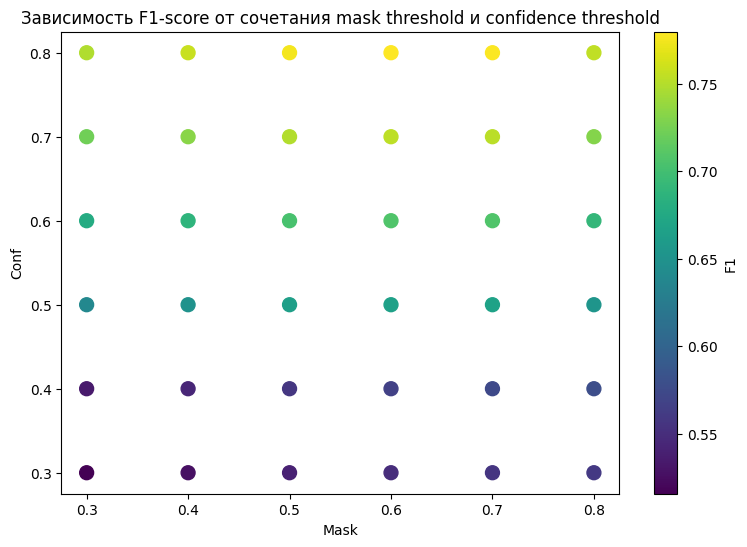

In [8]:
Conf_x = []
Mask_x = []
F1_y = []
for dict in results:
    Conf_x.append(dict["conf_thresh"])
    Mask_x.append(dict["mask_thresh"])
    F1_y.append(np.round(dict["f1_score"],4))

plt.figure(figsize=(9, 6))
scatter = plt.scatter(Mask_x, Conf_x, c=F1_y, cmap='viridis', s=100)
plt.colorbar(scatter, label='F1')
plt.xlabel('Mask')
plt.ylabel('Conf')

plt.title('Зависимость F1-score от сочетания mask threshold и confidence threshold')
plt.show()